# Train Image AE

In [3]:
%load_ext autoreload
%autoreload 2

import joblib
import sys
from os.path import join
import torch

fp_code_folder = "../../"
fp_project_folder = join(fp_code_folder, "../")
sys.path.append(fp_code_folder)

fp_checkpoint_folder = join(fp_project_folder, "checkpoints")

from src.configs.image_config import fp_data_dfs_file, col_info
from src.preprocessing.pytorch_preprocessing import get_pytorch_split_dict, get_ae_image_dl
from src.filepath_manager import FilePath

from src.models.resnet_bilateral.resnet_bilateral_model import ResNet18Bilateral
from src.models.resnet_bilateral.ae_trainer import train_resnet_ae
from src.pytorch_training.misc import set_seed_pytorch
from src.models.resnet_bilateral.ae_evaluator import get_ae_losses, \
    show_best_reconstructions, show_worst_reconstructions

fp = FilePath(model_name="resnet_bilateral_ae", fp_checkpoint_folder=fp_checkpoint_folder)

batch_size = 64
eval_batch_size = 64*4

seed_no = 2024

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [6]:
data_dfs = joblib.load(fp_data_dfs_file)

In [7]:
set_seed_pytorch(seed_no)
data_dls = get_pytorch_split_dict(
    data_dict=data_dfs, col_info=col_info, 
    batch_size=batch_size, eval_batch_size=eval_batch_size, shuffle_train=True,
    dl_func=get_ae_image_dl
)

## Train AE

In [ ]:
resnet_bilateral = ResNet18Bilateral(num_classes=col_info["num_classes"])
ae_history = train_resnet_ae(
    model=resnet_bilateral, **data_dls, 
    fp_model=fp.fp_model_file, fp_history=fp.fp_history_file, # Where to store trained model and history of training
    max_epochs=500,  
    lr=0.001, weight_decay=0.0001,  # Training parameters
    patience=10, metric_to_monitor = "mse", maximise=False, # For early stopping
    verbose=True,
    seed = seed_no
) 

## Evaluate

In [ ]:
test_losses = get_ae_losses(model=resnet_bilateral, dl=data_dls["test_dl"])
joblib.dump(test_losses, fp.fp_loss_file)

In [ ]:
resnet_bilateral = torch.load(fp.fp_model_file)
test_losses = joblib.load(fp.fp_loss_file)
print("Test Reconstruction MSE:", test_losses.mean())

Test Reconstruction MSE: 0.01153652


Best Reconstructions:
- Get Indices
- Images and reconstructions


  0%|          | 0/5 [00:00<?, ?it/s]

- Plotting


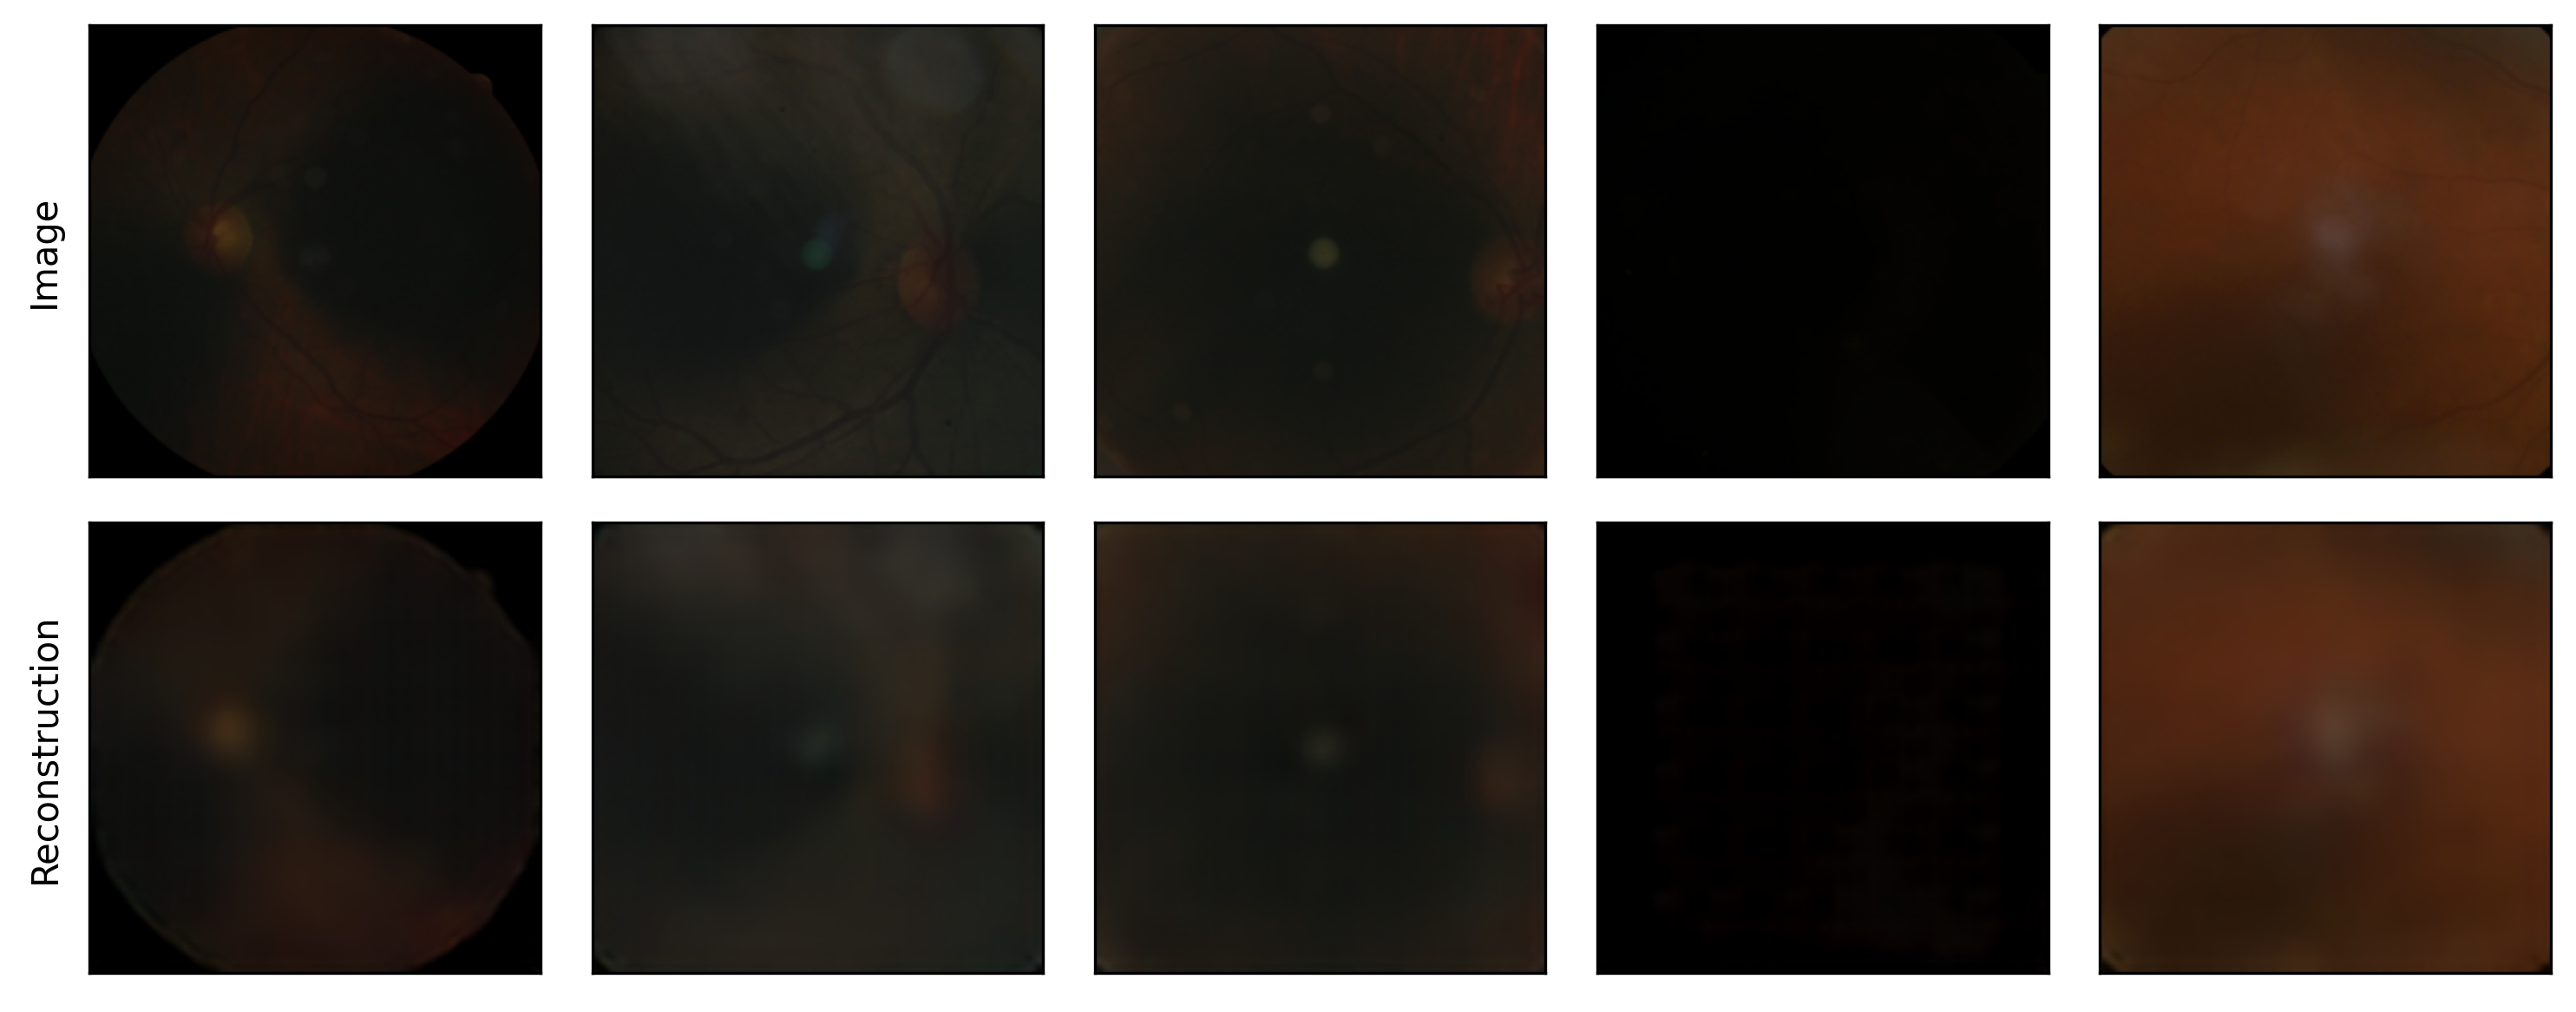

Worst Reconstructions:
- Get Indices
- Images and reconstructions


  0%|          | 0/5 [00:00<?, ?it/s]

- Plotting


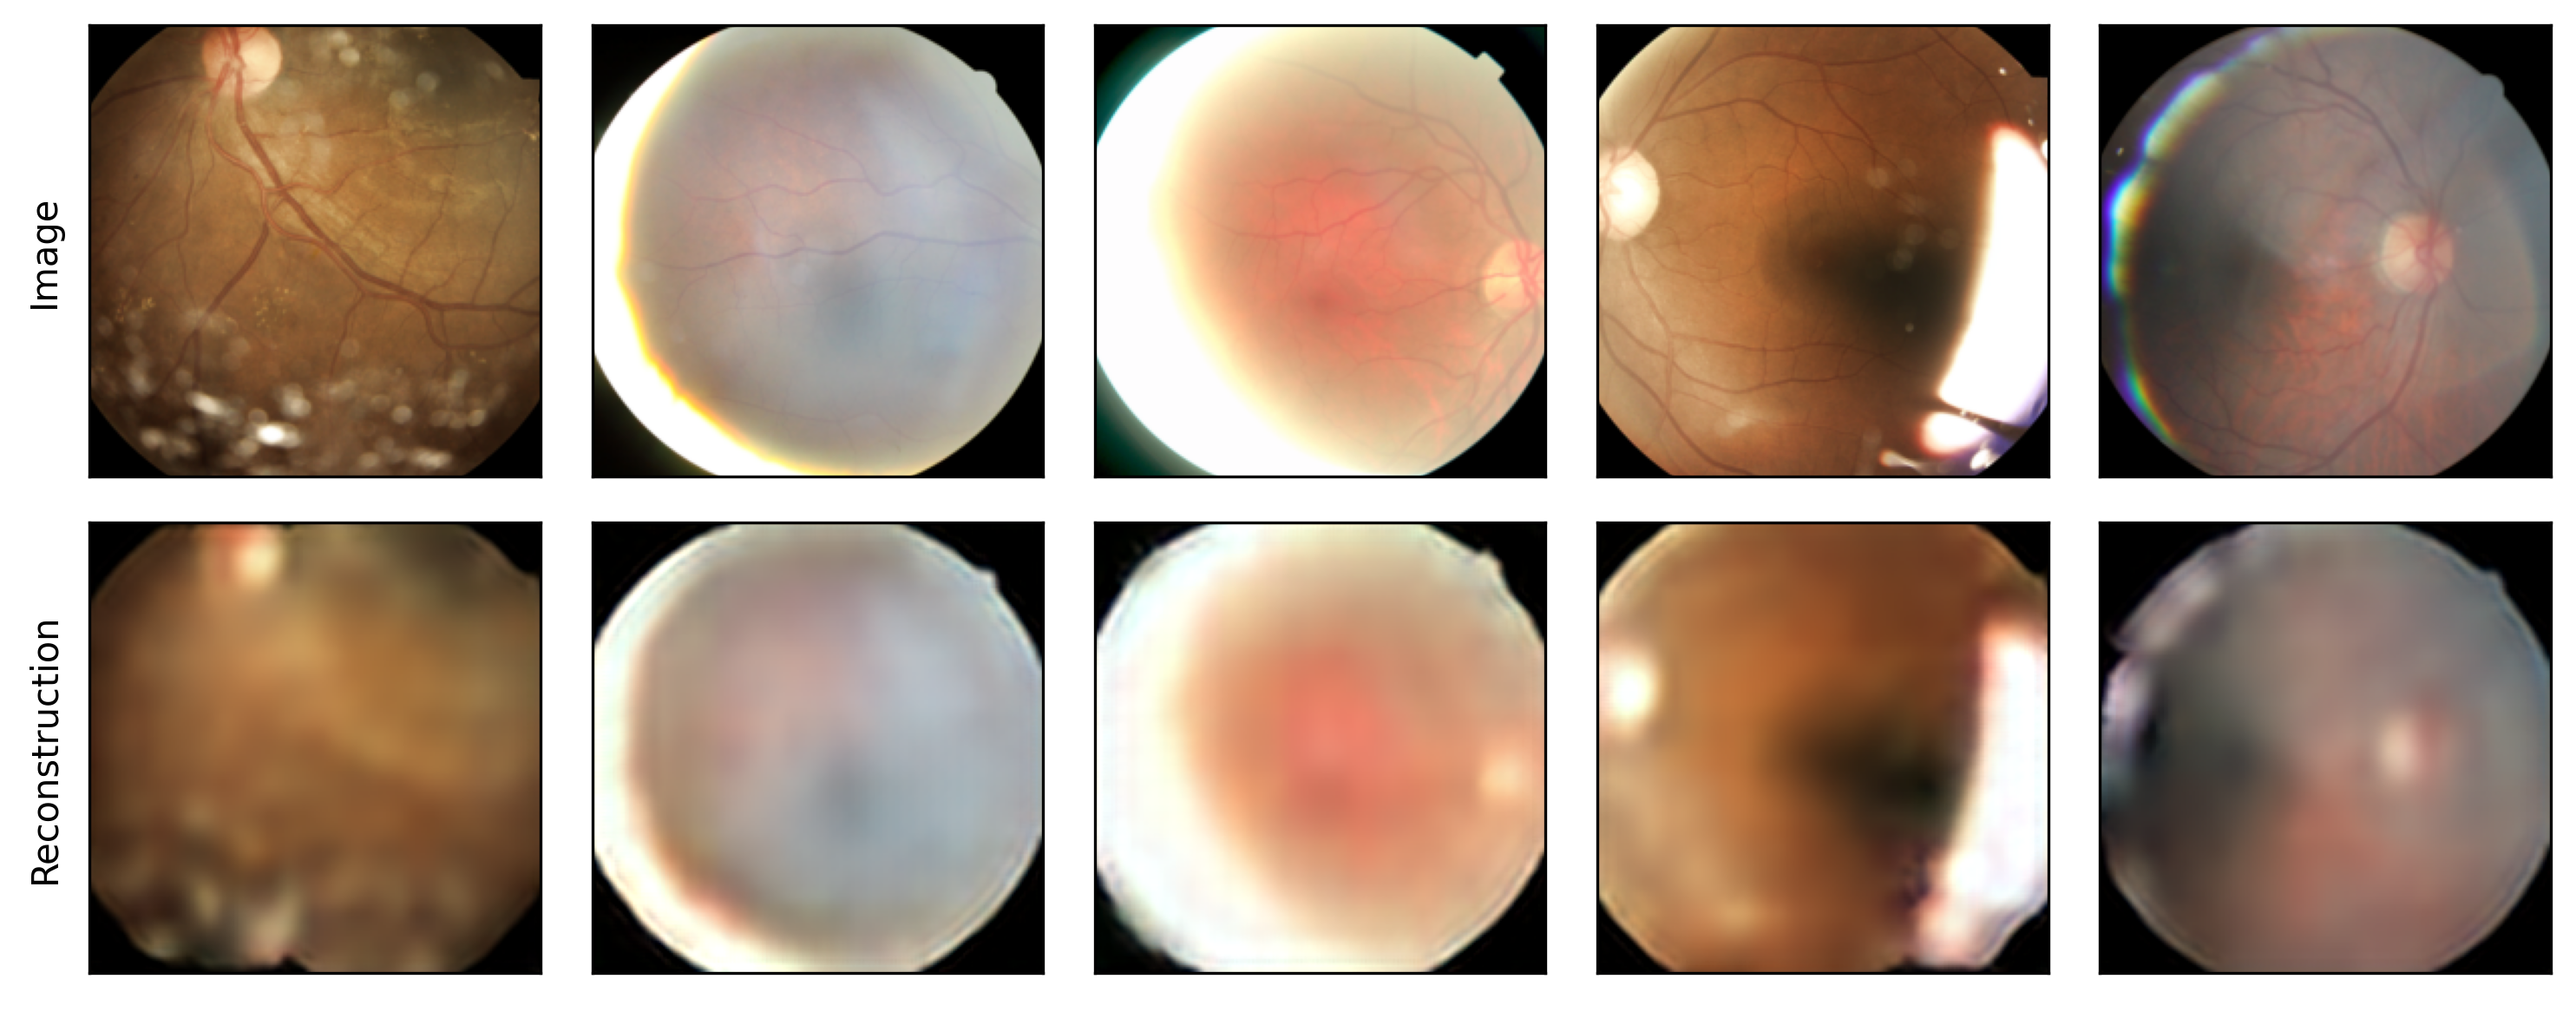

In [21]:
# Show Images
print("Best Reconstructions:")
show_best_reconstructions(
    model=resnet_bilateral, df=data_dfs["test_df"], col_info=col_info,
    losses=test_losses, 
    num_examples=5, pic_size=2, dpi=300, fp_fig=fp.fp_best_recon_fig_file
)
print("Worst Reconstructions:")
show_worst_reconstructions(
    model=resnet_bilateral, df=data_dfs["test_df"], col_info=col_info,
    losses=test_losses,
    num_examples=5, pic_size=2, dpi=300, fp_fig=fp.fp_worst_recon_fig_file
)